<a href="https://colab.research.google.com/github/HopeRetina/btc_forecasting_LSTM/blob/main/hope_try_bitcoin_price_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here I used LSTM to predict the price of bitcoin using the hourly data
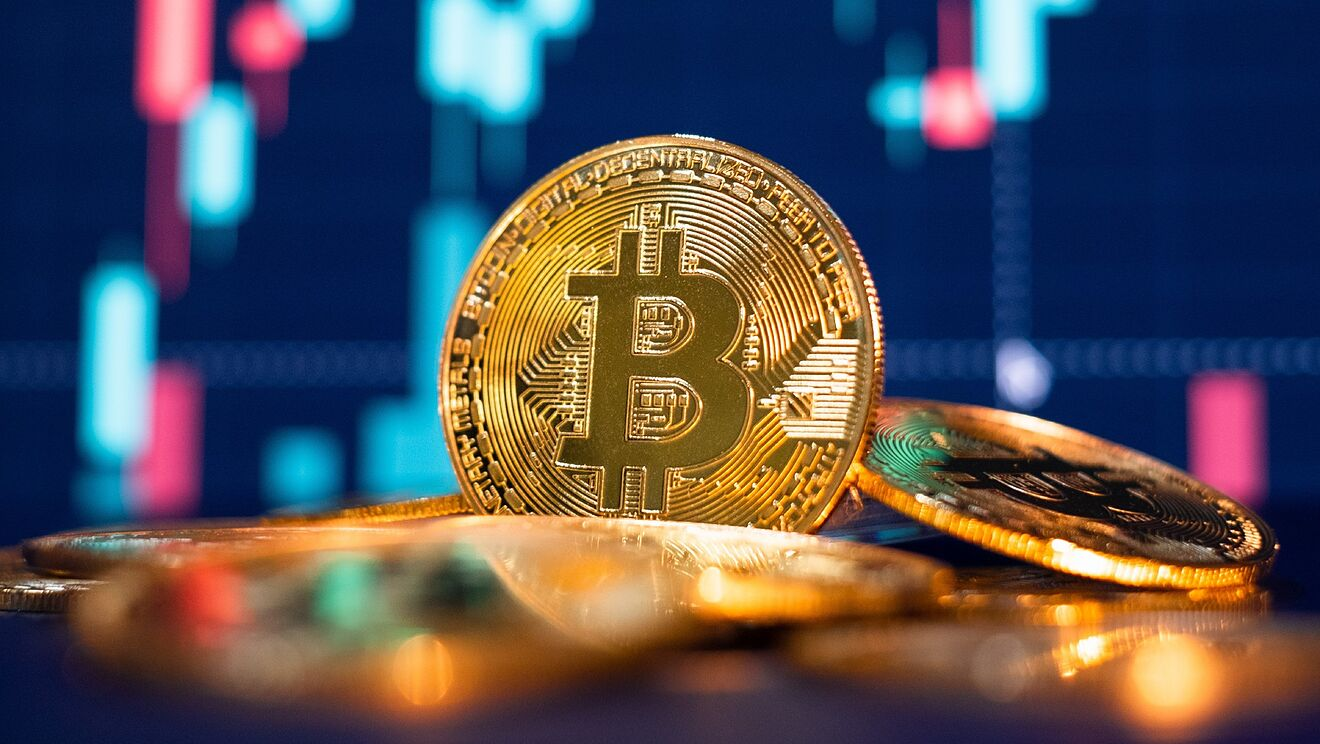

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data_collection/

/content/drive/MyDrive/data_collection


In [ ]:
# Load the dataset
df = pd.read_csv('BTC_hourly.csv')

df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


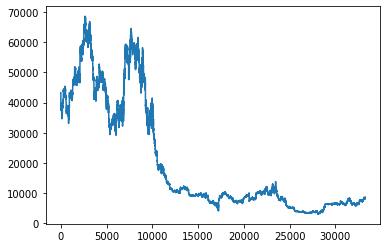

In [ ]:
plt.plot(df['close'])
plt.show()

In [ ]:
# Convert the df to a numpy array
btc = df['close'].to_numpy()
btc = btc.astype('float32') #Convert values to float

In [ ]:
type(btc)

numpy.ndarray

In [ ]:
btc.shape

(33259,)

In [ ]:
# Since the sequence of the data is critical, we can't randomly split the data. Instead, I'll take the first 70% as the training data.

train_size = int(len(btc) * 0.7)
# test_size = len(btc) - train_size
# train, test = btc[0:train_size,:], btc[train_size:len(btc),:]

train = btc[:train_size]
test = btc[train_size:]

In [ ]:
len(train)

23281

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the training set, and using the variables obtained from the training set on the testing set

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train.reshape(-1, 1)) 

train_scaled = scaler.transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

##Now use timeseries generator from Keras to generate data in sequences

In [ ]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

#Sequence size has an impact on prediction
seq_size = 7  ## number of steps (lookback)
num_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

Total number of samples in the original training data =  23281
Total number of samples in the generated data =  23274


In [ ]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

In [ ]:
# Also do the test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7

#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  9978
Total number of samples in the generated data =  9971


##Now build the model and train

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

#Define Model 
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_size, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(7))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 50,375
Trainable params: 50,375
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
# Fit
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=3, steps_per_epoch=10)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


10/10 [==============================] - 24s 2s/step - loss: 0.3240 - val_loss: 0.0013
Epoch 2/3
10/10 [==============================] - 21s 2s/step - loss: 0.1110 - val_loss: 0.0112
Epoch 3/3
10/10 [==============================] - 18s 2s/step - loss: 0.0366 - val_loss: 0.0475


##Visualization

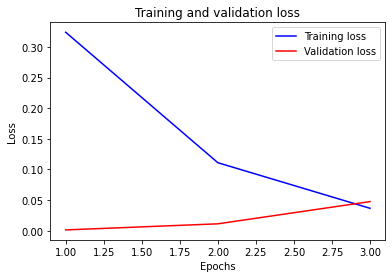

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Forecast

In [ ]:
prediction = [] 

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, num_features) #Reshape

In [ ]:
current_batch.shape

(1, 7, 1)

In [ ]:
type(current_batch)

numpy.ndarray

In [ ]:
cur_prd = model.predict(current_batch)

In [ ]:
current_batch[:,1:,:]

array([[[0.10880935],
        [0.10951383],
        [0.10890794],
        [0.10851794],
        [0.10992569],
        [0.10934582]]], dtype=float32)

In [ ]:
kk = np.append(current_batch, [0.5], axis=1)

kk

ValueError: ignored

In [ ]:
type(current_batch)

numpy.ndarray

In [ ]:
current_batch

array([[[0.10413387],
        [0.10880935],
        [0.10951383],
        [0.10890794],
        [0.10851794],
        [0.10992569],
        [0.10934582]]], dtype=float32)

In [ ]:
pred = model.predict(test_scaled)

In [ ]:
prediction = [] 

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, num_features) #Reshape

## Predict future, beyond test dates
future = 10 # minutes
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [current_pred],axis=1)
    

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")


ValueError: ignored

In [ ]:
# Hope DIY

testPred = model.predict(test_scaled.reshape(1, seq_size, num_features))

ValueError: ignored

In [1]:
!git init

Initialized empty Git repository in /content/.git/


In [2]:
!git config — global user.email “hope.qshi@gmail.com”
!git config — global user.name “HopeRetina”

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

In [3]:
!git add -A

In [4]:
!git commit -m 'first commit'


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@fcb35f3a7f35.(none)')


In [7]:
!git remote add origin https://github.com/HopeRetina/btc_forecasting_LSTM

In [8]:
!git push -u origin <branch>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `git push -u origin <branch>'
